# Objective of this notebook is to convert all images to axial

In [11]:
import os
import glob
import pydicom
import numpy as np
import cv2
from scipy.ndimage import zoom
from tqdm import tqdm
import cv2
import pandas as pd
import math


In [110]:
import os
import glob
import pydicom
import numpy as np
import cv2
from scipy.ndimage import zoom
from tqdm import tqdm
import cv2
import pandas as pd
import math

def get_pixels_hu(slices, convert=False):
    image = np.stack([s.pixel_array for s in slices])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    if convert:
        # Convert to Hounsfield units (HU)
        for slice_number in range(len(slices)):

            intercept = slices[slice_number].RescaleIntercept
            slope = slices[slice_number].RescaleSlope
            print(intercept, slope)
            if slope != 1:
                image[slice_number] = slope * image[slice_number].astype(np.float64)
                image[slice_number] = image[slice_number].astype(np.int16)

            image[slice_number] += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

def load_slices(patient, selective=True):
    '''
    Load slices
    '''
    sorted_imgs = sorted(glob.glob('./datasets/kaggle-brain-tumor/train/'+patient+'/FLAIR/*.dcm'))
    slices = [pydicom.read_file(s) for s in sorted_imgs]
    
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

def quantile_filtering(images, lower=0.20, upper=0.80):
    # selective filtering
    num_images = images.shape[0]
    #print(images.shape)
    lb = math.floor(lower*num_images)
    ub = math.floor(upper*num_images)
    images = images[lb:ub]
    #print(images.shape)
    return images
        
def remove_blanks(hu_images):
    '''
    remove blank images form the collection
    '''
    blanked_images = []
    for i in range(hu_images.shape[0]):
        if np.min(hu_images[i]) != np.max(hu_images[i]):
            blanked_images.append(hu_images[i])
    return np.array(blanked_images, dtype=np.int16)

def siz(img):
    desired_depth = 64
    current_depth = img.shape[0]
    depth = current_depth / desired_depth
    depth_factor = 1 / depth
    img_new = zoom(img, (depth_factor, 1, 1), mode='nearest')
    return img_new

def normalize(img, mini, maxi):
    img = (img - mini) / (maxi - mini)
    return img

def resize_images(img, resize_dim=256):
    resized = []
    for i in range(img.shape[0]):
        im = img[i]
        img_t = cv2.resize(im, (resize_dim, resize_dim))
        resized.append(img_t)
    return np.array(resized)

def get_label(patient, df):
    label = df._get_value(patient, 'MGMT_value')
    if label == 1:
        label = np.array(1)
    elif label == 0:
        label = np.array(0)
    return label

def zero_center(images, mean):
    images = images - mean
    return images
    
# Convert the Image Orientation Patient tag cosine values into a text string of the plane.
# This represents the plane the image is 'closest to' .. it does not explain any obliqueness
def get_image_plane(loc):

    row_x = round(loc[0])
    row_y = round(loc[1])
    row_z = round(loc[2])
    col_x = round(loc[3])
    col_y = round(loc[4])
    col_z = round(loc[5])

    if row_x == 1 and row_y == 0 and col_x == 0 and col_y == 0:
        return "Coronal"

    if row_x == 0 and row_y == 1 and col_x == 0 and col_y == 0:
        return "Sagittal"

    if row_x == 1 and row_y == 0 and col_x == 0 and col_y == 1:
        return "Axial"

    return "Unknown"

def cropped_images(images):
    '''
    Input images numpy array (D, H, W) (D = Depth)
    '''
    min_1=np.array(np.nonzero(images)).min(axis=1)
    max_1=np.array(np.nonzero(images)).max(axis=1)
    min_crop = min(min_1[1], min_1[2])
    max_crop = max(max_1[1], max_1[2])
    return images[min_1[0]:max_1[0], min_crop:max_crop,min_crop:max_crop]


In [82]:
patients = os.listdir('./datasets/kaggle-brain-tumor/train')

In [20]:
sagittal = []
axial = []
coronal = []

for patient in tqdm(patients):
    if patient in ['00109', '00123', '00709']:
        continue
    slices = load_slices(patient)
    orientation = get_image_plane(slices[0][0x0020, 0x0037])
    if orientation == "Coronal":
        print(patient)
        break
    if orientation == "Saggital":
        saggital.append(patient)
    if orientation == "Axial":
        axial.append(patient)

  0%|                                                   | 0/585 [00:01<?, ?it/s]

00000


Coronal


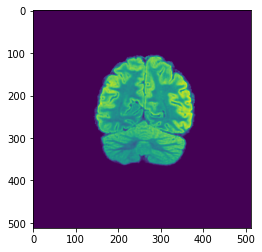

In [111]:
# Confirm 00000 is not axial
import matplotlib.pyplot as plt
slices = load_slices('00000')
orientation = get_image_plane(slices[0][0x0020, 0x0037])
print(orientation)
hu_images = get_pixels_hu(slices)
images = remove_blanks(hu_images)
plt.imshow(images[20])

In [112]:
images = images.transpose((1,0,2))

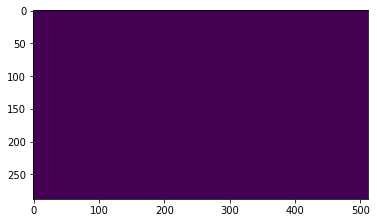

In [115]:
plt.imshow(images[25])

In [117]:
np.unique(images[25])

array([0], dtype=int16)

# Above image is coronal
Aim is to convert all to saggital

In [106]:
def get_image_plane(data):
    x1, y1, _, x2, y2, _ = [round(j) for j in data.ImageOrientationPatient]
    cords = [x1, y1, x2, y2]

    if cords == [1, 0, 0, 0]:
        return 'Coronal'
    elif cords == [1, 0, 0, 1]:
        return 'Axial'
    elif cords == [0, 1, 0, 0]:
        return 'Sagittal'
    else:
        return 'Unknown'

def get_voxel(study_id, scan_type='FLAIR'):
    slices = load_slices('00000')
    hu_images = get_pixels_hu(slices)
    imgs = remove_blanks(hu_images)
    #plt.imshow(images[10])
    
    positions = []
    for iii in slices:
        positions.append(iii.ImagePositionPatient)
        #print(iii.ImagePositionPatient)
    
    plane = get_image_plane(iii)
    print(plane)
    #voxel = np.stack(imgs)
    voxel = imgs
    # reorder planes if needed and rotate voxel
    if plane == "Coronal":
        print('tes coronal')
        print(positions[0][1], positions[-1][1])
        if positions[0][1] < positions[-1][1]:
            voxel = voxel[::-1]
            print(f"{study_id} {scan_type} {plane} reordered")
        voxel = voxel.transpose((1, 0, 2))
    elif plane == "Sagittal":
        if positions[0][0] < positions[-1][0]:
            voxel = voxel[::-1]
            print(f"{study_id} {scan_type} {plane} reordered")
        voxel = voxel.transpose((1, 2, 0))
        voxel = np.rot90(voxel, 2, axes=(1, 2))
    elif plane == "Axial":
        if positions[0][2] > positions[-1][2]:
            voxel = voxel[::-1]
            print(f"{study_id} {scan_type} {plane} reordered")
        voxel = np.rot90(voxel, 2)
    else:
        raise ValueError(f"Unknown plane {plane}")
    return voxel, plane
    

In [107]:
v,p = get_voxel(study_id='00002')

Coronal
tes coronal
90.3865 31.5865


In [73]:
imgs = []
sorted_imgs = sorted(glob.glob('./datasets/kaggle-brain-tumor/train/'+'00002'+'/FLAIR/*.dcm'))
slices = [pydicom.read_file(s) for s in sorted_imgs]
#dcm_paths = sorted(glob.glob('./datasets/kaggle-brain-tumor/train/'+'00002'+'/FLAIR/*.dcm'))
#imges = [pydicom.read_file(s) for s in dcm_paths]

In [74]:
len(imges)

129

In [108]:
np.unique(slices[100].pixel_array)
img = slices[100].pixel_array
img = img.astype(np.int16)

In [79]:
np.unique(img)

array([0], dtype=int16)